In [1]:
import pandas as pd
import numpy as np 
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('input.csv',delimiter=',') # reading the csv file with , as the delimitor 

to_train = data.loc[data['Usage']=='Training',:] # Taking all instances (28,709) marked for as 'Training' for training data

# Taking instances(7178) marked as 'PublicTest' and 'PrivateTest' for testing data
to_test  = data.loc[np.logical_or(data['Usage']=='PublicTest', data['Usage']=='PrivateTest') ,:]

# dataset consists of 48x48 pixel gray scale images of faces.
# Splitting the image pixel data (separated by space) into dataframe with 2304 columns and changing the data type to 'int' 
train_X = np.array(to_train.iloc[:,1].str.split(expand=True).astype('int')) # train images data--train_X .shape -- (28709, 2304)
test_X =  np.array(to_test.iloc[:,1].str.split(expand=True).astype('int')) # test images data -- test_X .shape -- (7178, 2304)

train_Y = np.array(to_train.iloc[:,0]) # training labels -- train_Y.shape -- (28709,)
test_Y =  np.array(to_test.iloc[:,0]) # testing labels -- test_Y.shape -- (7178,)


# Parameter selection for HOG features 

The dataset provided consists of 48x48 pixel gray scale images of faces -- 48x48 =  2304 pixel data/features 

The agenda is to extract meaningful features of this 2304 and reduce the dimensional space.

Parameters:
1. pixels per cell  = 8 
        The 48x48 is divided into cells of 8x8 
2. Orientaions = 9 
        The  gradient orientation is quantisized into 9 bins
3. Cells per block = 2x2 
        The block size of 2x2 is selected for normalisation
    
Total No. of Features = (5x5)x(2x2)x(9) = 900 HOG features

2034 features of the origianl image are reduced to 900 HOG features ( Achieved around 60% reduction in the  dimensional space )

These reduced dimensions can be fed to the classifer for training.


In [3]:
ppc = 8 # setting pixels per cell 

# Extracting HOG fetures out of train images 

hog_images_train = []
hog_features_train = []

for image in train_X:
    image = image.reshape(48,48) # reshaping image pixel data into 48x48
    fd,hog_image = hog(image, orientations=9, pixels_per_cell=(ppc,ppc),cells_per_block=(2,2),block_norm= 'L2',visualise=True)
    hog_images_train.append(hog_image)
    hog_features_train.append(fd)

hog_features_train = np.array(hog_features_train) # converting them into a numpy array
#Saving float till 6 digits to reduce the size of the file
np.savetxt("HOG_train.csv", hog_features_train,fmt="%.6f",delimiter=",") # saving the HOG features of train images to a csv file


# Extracting HOG fetures out of test images 

hog_images_test = []
hog_features_test = []

for image in test_X:
    image = image.reshape(48,48)
    fd,hog_image = hog(image, orientations=9, pixels_per_cell=(ppc,ppc),cells_per_block=(2,2),block_norm= 'L2',visualise=True)
    hog_images_test.append(hog_image)
    hog_features_test.append(fd)

hog_features_test= np.array(hog_features_test)
#Saving float till 6 digits to reduce the size of the file
np.savetxt("HOG_test.csv", hog_features_test,fmt="%.6f",delimiter=",") # saving the HOG features of test images to a csv file


print('No of HOG features extracted out of an image:', len(hog_features_train[1]))

C:\Users\Rakesh Reddy\Anaconda3\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


No of HOG features extracted out of an image: 900


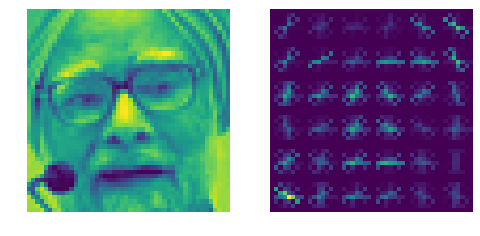

In [4]:
#Visualising a sample image and its HOG features 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(train_X[1].reshape(48,48))
ax2.axis('off')
ax2.imshow(hog_images_train[1])

In [5]:
# Setting training data and testing data --  HOG features & Class labels respectively -- to feed to a classifier
x_train, x_test = hog_features_train , hog_features_test
y_train, y_test = train_Y , test_Y

In [6]:
clf = svm.SVC()  # creating an SVM classifier 
clf.fit(x_train,y_train)  # training the classifier 

C:\Users\Rakesh Reddy\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [7]:
y_pred_test = clf.predict(x_test)  # predicting labels using the test data
print('Shape of predicted labels(y_pred): ',y_pred_test.shape)  # matches with 7178 instances fed as test data 

Shape of predicted labels(y_pred):  (7178,)


In [8]:
print("Accuracy for test data: ",(accuracy_score(y_test, y_pred_test)))  # Accuracy of prediction
print('\n')

# Classification report with precision, recall & f1-score 
print('Classification report for test data:','\n','\n',classification_report(y_test, y_pred_test)) 

Accuracy for test data:  0.8057954862078573


Classification report for test data: 
 
               precision    recall  f1-score   support

           0       0.80      0.99      0.88      5404
           1       0.87      0.25      0.39      1774

   micro avg       0.81      0.81      0.81      7178
   macro avg       0.84      0.62      0.64      7178
weighted avg       0.82      0.81      0.76      7178



In [9]:
# Saving test set result
index_test = np.array(to_test.iloc[:,0].index) # Extracting indexes (row or image number) for test instances
test_output = np.array((y_pred_test,index_test),dtype='int').T

np.savetxt("test_result.csv", test_output,fmt='%i',delimiter=",")

In [10]:
y_pred_train = clf.predict(x_train) 
print("Accuracy for train data: ",(accuracy_score(y_train, y_pred_train)))  # Accuracy of prediction
print('\n')

# Classification report with precision, recall & f1-score 
print('Classification report for train data:','\n','\n',classification_report(y_train, y_pred_train)) 

Accuracy for train data:  0.7998188721306907


Classification report for train data: 
 
               precision    recall  f1-score   support

           0       0.80      0.99      0.88     21494
           1       0.86      0.24      0.38      7215

   micro avg       0.80      0.80      0.80     28709
   macro avg       0.83      0.61      0.63     28709
weighted avg       0.81      0.80      0.75     28709

